In [1]:
from sklearn.datasets import fetch_openml
import numpy as np
mnist = fetch_openml('mnist_784', version=1, cache=True)

def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]
mnist.target = mnist.target.astype(np.int8) # fetch_openml() returns targets as strings
sort_by_target(mnist) # fetch_openml() returns an unsorted dataset
mnist

{'data': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'target': array([0, 0, 0, ..., 9, 9, 9], dtype=int8),
 'frame': None,
 'categories': {},
 'feature_names': ['pixel1',
  'pixel2',
  'pixel3',
  'pixel4',
  'pixel5',
  'pixel6',
  'pixel7',
  'pixel8',
  'pixel9',
  'pixel10',
  'pixel11',
  'pixel12',
  'pixel13',
  'pixel14',
  'pixel15',
  'pixel16',
  'pixel17',
  'pixel18',
  'pixel19',
  'pixel20',
  'pixel21',
  'pixel22',
  'pixel23',
  'pixel24',
  'pixel25',
  'pixel26',
  'pixel27',
  'pixel28',
  'pixel29',
  'pixel30',
  'pixel31',
  'pixel32',
  'pixel33',
  'pixel34',
  'pixel35',
  'pixel36',
  'pixel37',
  'pixel38',
  'pixel39',
  'pixel40',
  'pixel41',
  'pixel42',
  'pixel43',
  'pixel44',
  'pixel45',
  'pixel46',
  'pixel47',
  'pixel48',
  'pixel49',
  'pixel

In [2]:
X, y = mnist["data"], mnist["target"]
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


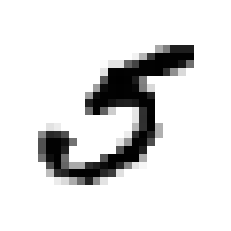

In [3]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

#Split data
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

#shuffle the training dataset
import numpy as np
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]
                                                   
# Simplify the problem (5 or not5)
y_train_5 = (y_train == 5) # True for all 5s, False for all other digits.
y_test_5 = (y_test == 5)

## SGD

In [4]:
# SGD algorithm
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)
print(sgd_clf.predict([some_digit]))

[ True]


In [5]:
# Cross validation
from sklearn.model_selection import cross_val_score
print(cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy"))

#Never classifier 5
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
never_5_clf = Never5Classifier()
print(cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy"))

[0.9621  0.97005 0.97005]
[0.9121  0.90715 0.9097 ]


In [6]:
# Confusion matrix
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_train_5, y_train_pred))

from sklearn.metrics import precision_score, recall_score, f1_score
print("Precision: ", precision_score(y_train_5, y_train_pred))# == 4344 / (4344 + 1307)
print("Recall   : ", recall_score(y_train_5, y_train_pred)) # == 4344 / (4344 + 1077)
print("F1 score : ",f1_score(y_train_5, y_train_pred))

[[53855   724]
 [ 1232  4189]]
Precision:  0.852635864034195
Recall   :  0.772735657627744
F1 score :  0.810721888910393


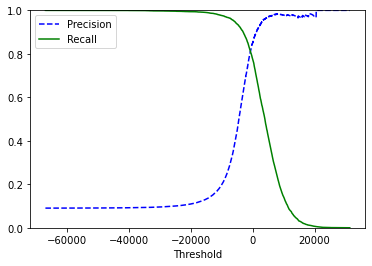

In [7]:
# Precision-Recall tradeoff
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()
#y_train_pred_90 = (y_scores > 70000) #We pick a threshold of 70000
#print("Precision: ", precision_score(y_train_5, y_train_pred_90))
#print("Recall:    ", recall_score(y_train_5, y_train_pred_90))

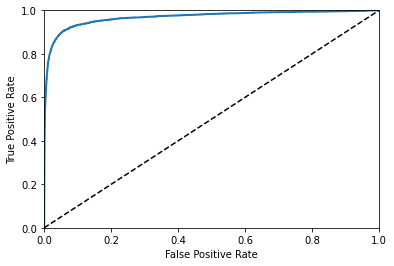

0.9682040109681068

In [8]:
#ROC curve
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
plot_roc_curve(fpr, tpr)
plt.show()
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

## Random Forest classification

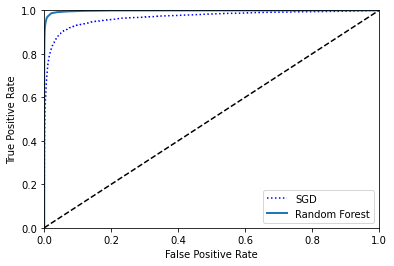

In [9]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

## Multiclass classification

In [ ]:
sgd_clf.fit(X_train, y_train) # y_train, not y_train_5
print(sgd_clf.predict([some_digit]))
some_digit_scores = sgd_clf.decision_function([some_digit])
print(some_digit_scores)

forest_clf.fit(X_train, y_train)
print("Random forest prediction: ",forest_clf.predict([some_digit]))
print(forest_clf.predict_proba([some_digit]))
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

## Error analysis

In [ ]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
print(conf_mx)

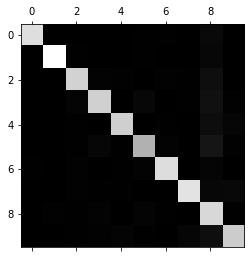

In [13]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()